## File Size

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load data

In [2]:
def load_data(path: str):
    with open(path) as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)

    if "_id" in df.columns:
        df = df.drop(columns="_id")
    if "file" in df.columns:
        df = df.drop(columns="file")
    if "unobfuscated_file" in df.columns:
      df = df.drop(columns="unobfuscated_file")

    return df

unobfuscated_unoptimized = load_data("./data/unoptimized/unobfuscated.json")
unobfuscated_optimized = load_data("./data/optimized/unobfuscated.json")

tigress_unoptimized = load_data("./data/unoptimized/tigress.json")
tigress_optimized = load_data("./data/optimized/tigress.json")

llvm_unoptimized = load_data("./data/unoptimized/llvm.json")
llvm_optimized = load_data("./data/optimized/llvm.json")

wasm_mutate_unoptimized = load_data("./data/unoptimized/wasm-mutate.json")
wasm_mutate_optimized = load_data("./data/optimized/wasm-mutate.json")

### Compute relative file size

In [3]:
def compute_relative_file_size(unobf_df, obf_df):
    obf_df['relative_file_size'] = None

    for index, row in obf_df.iterrows():
        name = row['name']
        file_size = row['file_size']
        unobf_file_size = unobf_df.loc[unobf_df['name'] == name, 'file_size'].iloc[0]
        relative_file_size = file_size / unobf_file_size

        obf_df.at[index, 'relative_file_size'] = relative_file_size
    return obf_df

tigress_unoptimized = compute_relative_file_size(unobfuscated_unoptimized, tigress_unoptimized)
tigress_optimized = compute_relative_file_size(unobfuscated_unoptimized, tigress_optimized)

llvm_unoptimized = compute_relative_file_size(unobfuscated_unoptimized, llvm_unoptimized)
llvm_optimized = compute_relative_file_size(unobfuscated_unoptimized, llvm_optimized)

wasm_mutate_unoptimized = compute_relative_file_size(unobfuscated_unoptimized, wasm_mutate_unoptimized)
wasm_mutate_optimized = compute_relative_file_size(unobfuscated_unoptimized, wasm_mutate_optimized)

### Configure Seaborn

In [4]:
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2,
    rc = {
      "figure.figsize": (10, 6),
      "errorbar.capsize": 0.05,
      "xtick.color": "#646464",
      "ytick.color": "#646464",
      "legend.loc": "best",
      "font.family": "Ubuntu",
    }
)

palette = "tab20"
edgecolor = "#646464"
errwidth = 1.8
capsize = 0.05

### Relative file size by category

In [5]:
def plot_relative_file_size_by_category(df, xlabel, xlabels=None, path=None):
  sns.barplot(data=df, 
              x='transformation', 
              y='relative_file_size', 
              hue='category', 
              palette=palette, 
              errwidth=errwidth, 
              capsize=capsize, 
              edgecolor=edgecolor)

  # Axis labels
  plt.ylabel('Relative File Size')
  plt.xlabel(xlabel)

  # Custom x labels
  if xlabels is not None: 
    plt.xticks(range(len(xlabels)), xlabels)

  # Capitalize the first letter of the entries in the legend
  legend = plt.legend(title='Category')
  for text in legend.get_texts():
      text.set_text(text.get_text().capitalize())

  # Save plot 
  if path is not None: 
    plt.savefig(path, dpi=300, bbox_inches="tight")

  # Show the plot 
  plt.show()

#### Tigress (unoptimized)

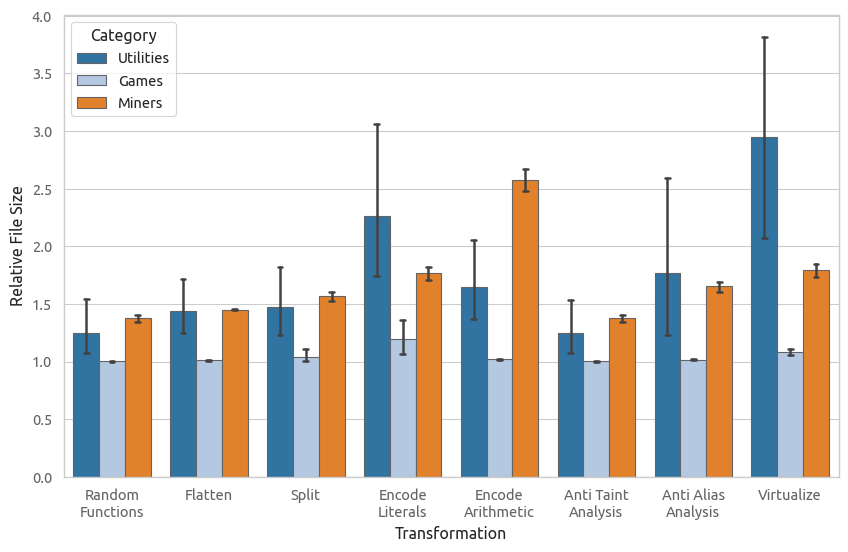

In [6]:
xlabels = [
        'Random\nFunctions',
        'Flatten',
        'Split',
        'Encode\nLiterals',
        'Encode\nArithmetic',
        'Anti Taint\nAnalysis',
        'Anti Alias\nAnalysis',
        'Virtualize'
    ]
plot_relative_file_size_by_category(tigress_unoptimized, xlabel='Transformation', xlabels=xlabels)

#### Tigress (Optimized)

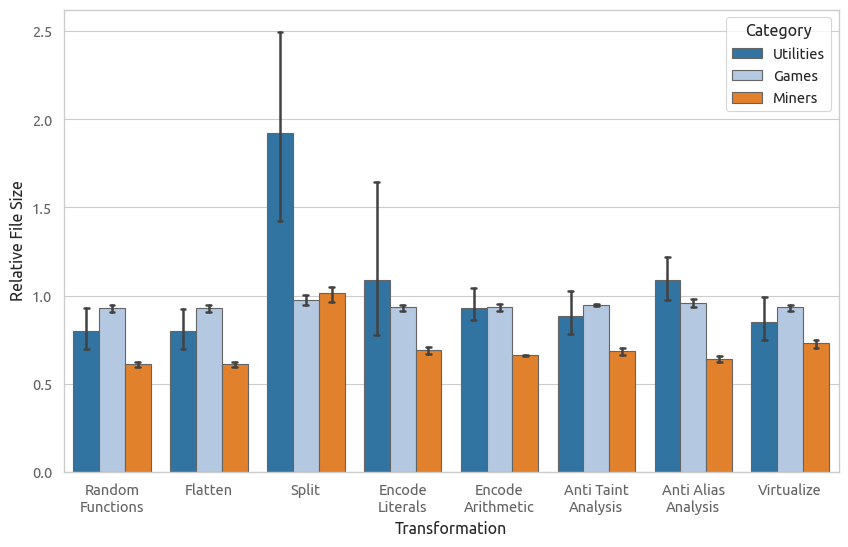

In [7]:
xlabels = [
        'Random\nFunctions',
        'Flatten',
        'Split',
        'Encode\nLiterals',
        'Encode\nArithmetic',
        'Anti Taint\nAnalysis',
        'Anti Alias\nAnalysis',
        'Virtualize'
    ]
plot_relative_file_size_by_category(tigress_optimized, xlabel='Transformation', xlabels=xlabels)

#### LLVM (Unoptimized)

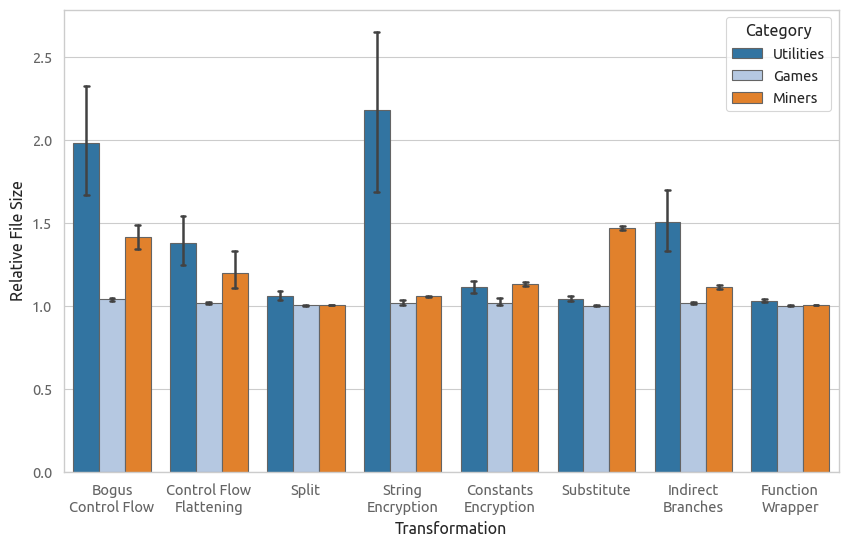

In [8]:
xlabels = [
    'Bogus\nControl Flow', 
    'Control Flow\nFlattening', 
    'Split', 
    'String\nEncryption', 
    'Constants\nEncryption', 
    'Substitute', 
    'Indirect\nBranches', 
    'Function\nWrapper'
]
plot_relative_file_size_by_category(llvm_unoptimized, xlabel='Transformation', xlabels=xlabels)

#### LLVM (Optimized)

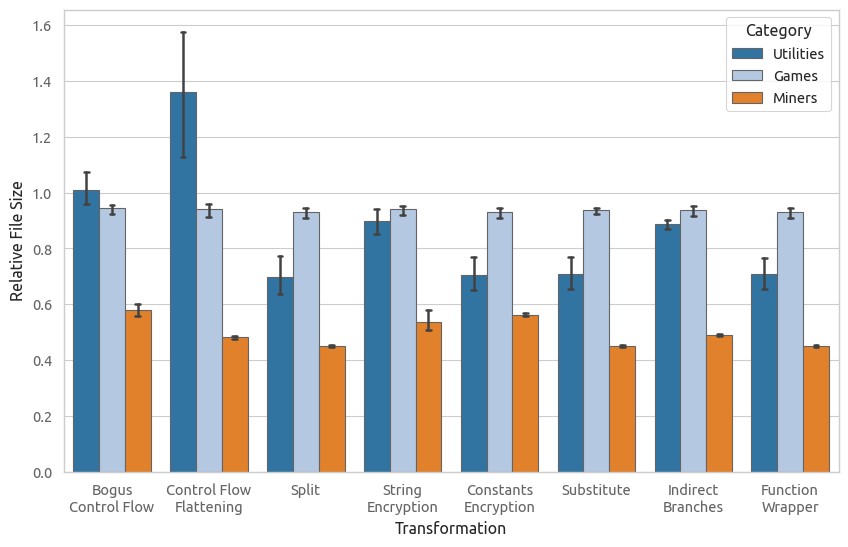

In [9]:
xlabels = [
    'Bogus\nControl Flow', 
    'Control Flow\nFlattening', 
    'Split', 
    'String\nEncryption', 
    'Constants\nEncryption', 
    'Substitute', 
    'Indirect\nBranches', 
    'Function\nWrapper'
]
plot_relative_file_size_by_category(llvm_optimized, xlabel='Transformation', xlabels=xlabels)

### Relative file size by mining variant

In [10]:
def plot_relative_file_size_by_mining_variant(df, path=None, legend_labels=None, spacing=1):
  names_to_include = ['cn-0', 'cn-1', 'cn-2', 'cn-r']
  df = pd.concat([df.query(f"name == '{name}'") for name in names_to_include])

  sns.barplot(data=df,
              x='name',
              y='relative_file_size', 
              hue='transformation', 
              palette=palette, 
              edgecolor=edgecolor,
              errwidth=errwidth, 
              capsize=capsize)

  plt.ylabel('Relative File Size')
  plt.xlabel('Cryptonight Variant')

  # Set custom xtick labels
  plt.xticks(range(len(names_to_include)))
  
  ax = plt.gca()
  ax.set_ylim(0, ax.get_ylim()[1] * spacing)

  # Get the default legend
  legend = ax.legend(title="Transformation", loc='upper center', ncol=4)
    
  # Update the legend text with custom labels, if provided
  if legend_labels:
      for i, text in enumerate(legend.get_texts()):
          text.set_text(legend_labels[i])


  # Save plot 
  if path is not None: 
    plt.savefig(path, dpi=300, bbox_inches="tight")

  plt.show()

#### Tigress (unoptimized)

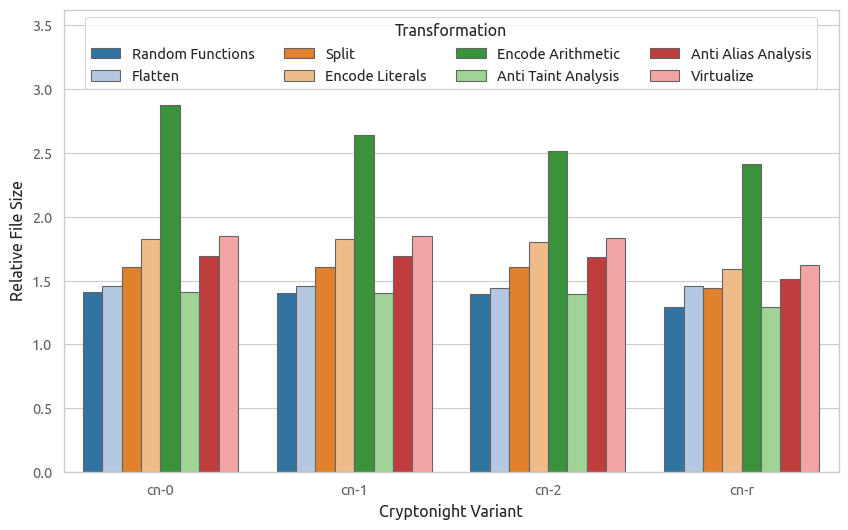

In [11]:
legend_labels = [
        'Random Functions',
        'Flatten',
        'Split',
        'Encode Literals',
        'Encode Arithmetic',
        'Anti Taint Analysis',
        'Anti Alias Analysis',
        'Virtualize'
]
plot_relative_file_size_by_mining_variant(tigress_unoptimized, spacing=1.2, legend_labels=legend_labels)

#### Tigress (optimized)

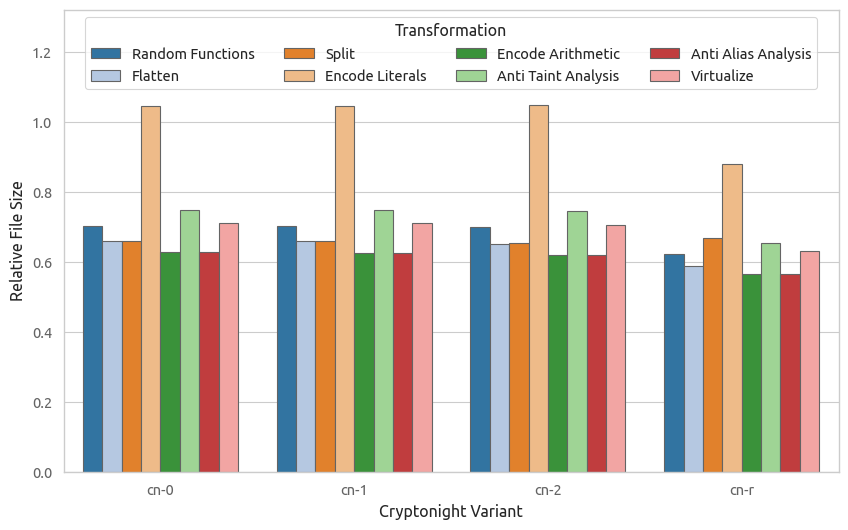

In [12]:
legend_labels = [
        'Random Functions',
        'Flatten',
        'Split',
        'Encode Literals',
        'Encode Arithmetic',
        'Anti Taint Analysis',
        'Anti Alias Analysis',
        'Virtualize'
]
plot_relative_file_size_by_mining_variant(tigress_optimized, spacing=1.2, legend_labels=legend_labels)

#### LLVM (unoptimized)

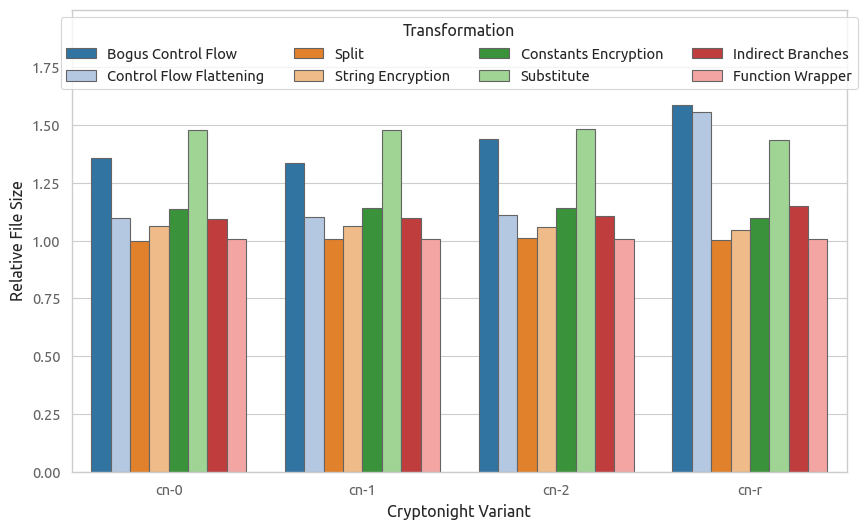

In [13]:
legend_labels = [
    'Bogus Control Flow', 
    'Control Flow Flattening', 
    'Split', 
    'String Encryption', 
    'Constants Encryption', 
    'Substitute', 
    'Indirect Branches', 
    'Function Wrapper'
]

plot_relative_file_size_by_mining_variant(llvm_unoptimized, spacing=1.2, legend_labels=legend_labels)

#### LLVM (optimized)

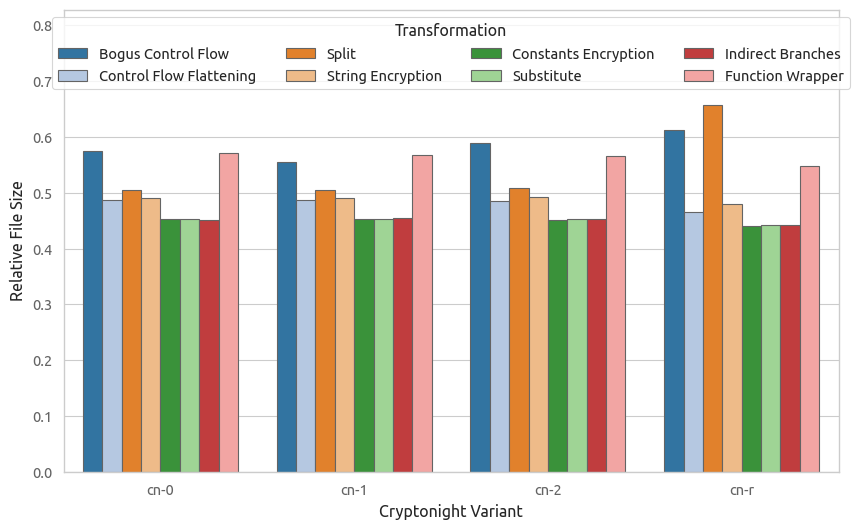

In [14]:
legend_labels = [
    'Bogus Control Flow', 
    'Control Flow Flattening', 
    'Split', 
    'String Encryption', 
    'Constants Encryption', 
    'Substitute', 
    'Indirect Branches', 
    'Function Wrapper'
]

plot_relative_file_size_by_mining_variant(llvm_optimized, spacing=1.2, legend_labels=legend_labels)

### Relative file size by iteration

#### Unoptimized

In [15]:
def plot_relative_file_size_by_iteration(df, hue):
  sns.lineplot(data=df, 
               x='iteration', 
               y='relative_file_size', 
               hue=hue, 
               )

  plt.ylabel('Relative File Size')
  plt.xlabel('Iteration')

  plt.ylim(0.99, 1.01)

  plt.legend(title='Program', loc='upper center', ncol=5, framealpha=1)

  plt.show()

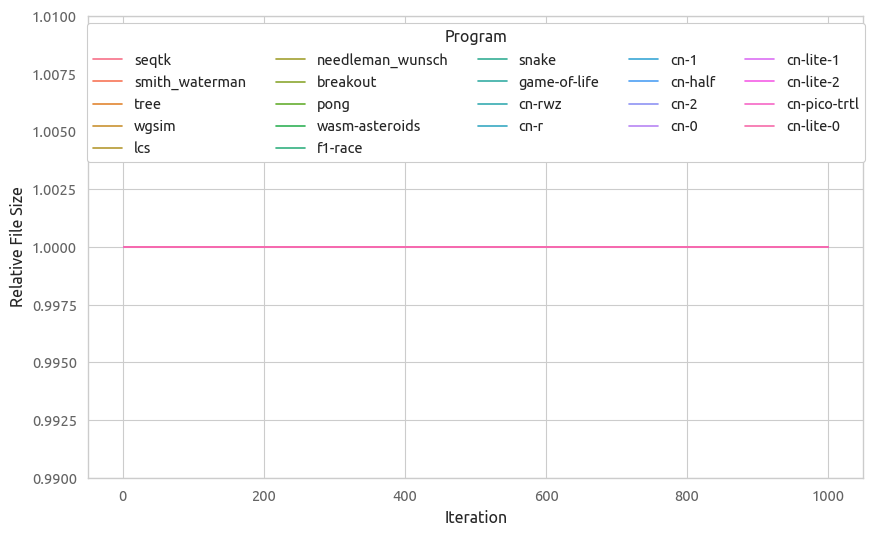

In [16]:
plot_relative_file_size_by_iteration(wasm_mutate_unoptimized, hue='name')

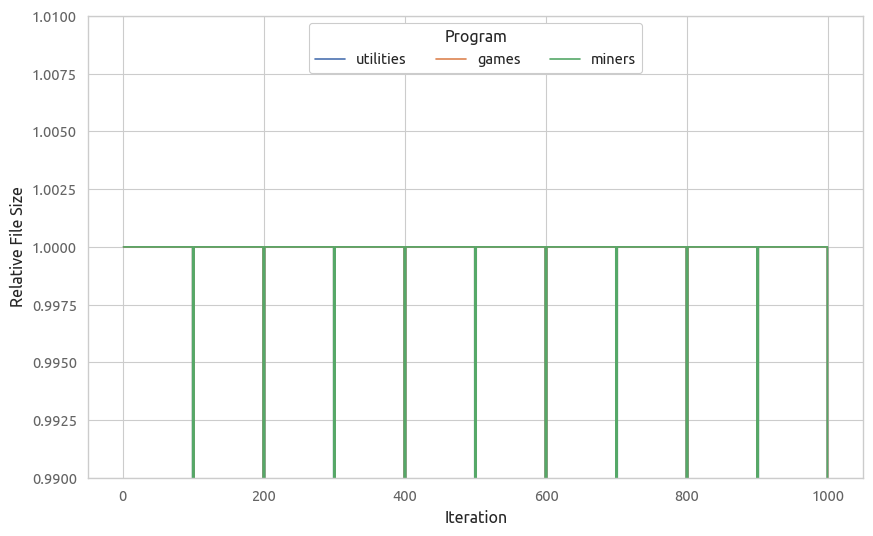

In [17]:
plot_relative_file_size_by_iteration(wasm_mutate_optimized, hue='category')

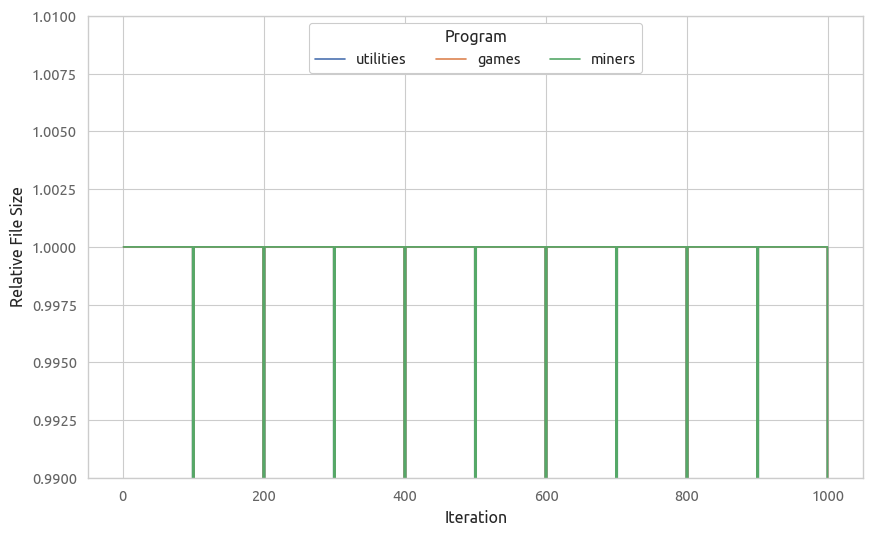

In [18]:
plot_relative_file_size_by_iteration(wasm_mutate_optimized, hue='category')